### Figure 4 - Numerical model

**Author:** Quentin Duez

This notebook builds and analyses a numerical model based on the reaction shown in Figure 3

**Outputs:** Figure 4

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from SALib.sample import sobol
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

sns.set_theme(style="ticks", context="paper")

In [2]:
# Reaction network definition
# Two steps reversible reactions : A + B <--> C + D <--> E


def d2_rev_dt(x, t, *args):
    A, B, C, D, E = x
    k1, km1, k2, km2, kf = args
    dAdt = (
        -k1 * A * B
        + km1 * C
        + kf * A0_ss * (1 + np.sin(2 * np.pi * t / PERIOD))
        - kf * A
    )
    dBdt = -k1 * A * B + km1 * C - kf * B + kf * B0_ss
    dCdt = k1 * A * B - km1 * C - k2 * C * D + km2 * E - kf * C
    dDdt = -k2 * C * D + km2 * E - kf * D + kf * D0_ss
    dEdt = k2 * C * D - km2 * E - kf * E
    return dAdt, dBdt, dCdt, dDdt, dEdt

In [3]:
# Fitting functions


def sinfunc(t, A, w, p, c):
    return A * np.sin(np.pi * (t - p) / w) + c
    # return A * np.sin(w*t + p) + c


def fit_sin(
    tt, yy, PERIOD
):  # Scooped from https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1] - tt[0]))  # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    # guess_freq = 1./ PERIOD
    # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.0**0.5
    guess_offset = np.mean(yy)
    guess = np.array(
        [guess_amp, PERIOD / 2, 0.0, guess_offset]
    )  # Guess phase = 0; check what works better

    popt, pcov = curve_fit(
        sinfunc,
        tt,
        yy,
        p0=guess,
        bounds=(
            (0, (PERIOD - 0.0001) / 2, -np.inf, -np.inf),
            (np.inf, (PERIOD + 0.0001) / 2, np.inf, np.inf),
        ),
    )
    A, w, p, c = popt
    f = w / (2.0 * np.pi)
    period = w * 2
    fitfunc = lambda t: A * np.sin(np.pi * (t - p) / w) + c
    return {
        "amp": A,
        "omega": w,
        "phase": p,
        "offset": c,
        "freq": f,
        "period": period,
        "fitfunc": fitfunc,
        "maxcov": np.max(pcov),
        "rawres": (guess, popt, pcov),
    }


def fit_sin_CSTR(t, conc, eq_time, PERIOD):
    t_filtered = t[eq_time:]
    conc_filtered = conc[eq_time:]

    res = fit_sin(t_filtered, conc_filtered, PERIOD)
    ypred = sinfunc(t_filtered, res["amp"], res["omega"], res["phase"], res["offset"])
    r2 = r2_score(conc_filtered, ypred)
    # print(r2_score(conc_filtered, ypred))
    phase = res["phase"]
    amp = res["amp"]

    if abs(phase) > PERIOD:
        ntot = abs(phase) / PERIOD
        nunits = ntot // 1
        if nunits > 0:
            coma = ntot - nunits
        else:
            coma = 0
        phase = coma * PERIOD
    else:
        phase = phase

    if r2 > 0.2:  # Condition for not trying to interpret weird data
        rel_amp = (
            abs(res["amp"]) / res["offset"]
        )  # Calculate the amplitude of the oscillation relative to the ion signal

        # Get time delay from the phase (empirically determined, was tricky for me brain)
        if (res["amp"] > 0) & (phase > 0):
            delay = phase + 0.5 * res["omega"]
        elif (res["amp"] > 0) & (phase < 0):
            delay = phase + 2.5 * res["omega"]
        else:
            pass
    else:
        rel_amp = 0
        delay = 0
        phase = 0

    return (rel_amp, delay, r2, phase, amp)

In [4]:
# Model evaluation functions for sensitivity analysis


def model_evaluate_reversible(model, param_values):
    fit_df = pd.DataFrame()
    for i, params in enumerate(param_values):

        klist = params.tolist()
        t = np.linspace(0, 1000, 1001)

        x0 = np.zeros(
            len(klist) + 1
        )  # initial conditions !! Number of compounds different than for nonreversible !!
        x0[0] = 0.001  # Define the concentration of the first compound
        sol = odeint(model, x0, t, args=(*klist, kf))
        num_sol = sol.shape[1]

        s = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        s = s[:num_sol]

        E_avg = sol[:, 4].mean()
        C_avg = sol[:, 2].mean()
        A_avg = sol[:, 0].mean()

        fit_dict = dict()
        for char in s:
            out = sol[:, s.index(char)]
            fit = fit_sin_CSTR(t, out, eq_time, PERIOD)
            if (fit[2] > 0.5) & (C_avg > 0.01 * A_avg) & (E_avg > 0.01 * A_avg):
                fit_dict.update(
                    {
                        "k1": klist[0],
                        "km1": klist[1],
                        "k2": klist[2],
                        "km2": klist[3],
                        f"rel_amp_{char}": fit[0],
                        f"time_delay_{char}": fit[1],
                    }
                )
            else:
                fit_dict.update(
                    {
                        "k1": klist[0],
                        "km1": klist[1],
                        "k2": klist[2],
                        "km2": klist[3],
                        f"rel_amp_{char}": 1,
                        f"time_delay_{char}": 0,
                    }
                )

        fit_df_temp = pd.DataFrame(fit_dict, index=[0])
        fit_df = pd.concat([fit_df, fit_df_temp])

    return fit_df

In [5]:
# Initial oscillations
A0_ss = 0.001  # mol/L
B0_ss = 0.0004  # mol/L - For 2nd order reactions
D0_ss = 0.05  # mol/L - For 2nd order reactions
TAU = 30  # minutes - Residence time
PERIOD = 120  # min
kf = 1 / TAU  # = flowrate (µL/min)/Reactor volume (µL) = 1/residence time (min)
eq_time = 3 * TAU  # The CSTR should be equilibrated at ~4-5x the residence time

### Two steps reversible reaction A + B <--> C + D <--> E

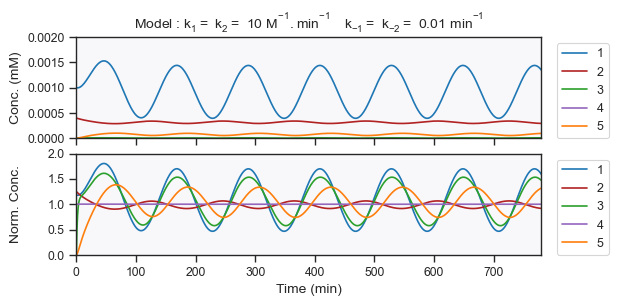

In [6]:
# With fixed k1, k2

k1 = 10  # M-1 min-1
k2 = 10  # M-1 min-1
km1 = 0.01  # min-1
km2 = 0.01  # min-1

t = np.linspace(0, 1000, 1001)
x0 = 0.001, 0.0004, 0, 0.05, 0  # initial conditions
sol = odeint(d2_rev_dt, x0, t, args=(k1, km1, k2, km2, kf))

sol_noreaction = odeint(
    d2_rev_dt, x0, t, args=(0, 0, 0, 0, kf)
)  # model the oscillation when no reaction takes place

A_overlay = sol[:, 0] / sol[800:, 0].mean()
B_overlay = sol[:, 1] / sol[800:, 1].mean()
C_overlay = sol[:, 2] / sol[800:, 2].mean()
D_overlay = sol[:, 3] / sol[800:, 3].mean()
E_overlay = sol[:, 4] / sol[800:, 4].mean()

fig, ax = plt.subplots(2, 1, figsize=(6, 2))

params = {"mathtext.default": "regular"}
plt.rcParams.update(params)
sns.lineplot(x=t, y=A_overlay, ax=ax[1], c="tab:blue", label="1")
sns.lineplot(x=t, y=B_overlay, ax=ax[1], c="firebrick", label="2")
sns.lineplot(x=t, y=C_overlay, ax=ax[1], c="tab:green", label="3")
sns.lineplot(x=t, y=D_overlay, ax=ax[1], c="tab:purple", label="4")
sns.lineplot(x=t, y=E_overlay, ax=ax[1], c="tab:orange", label="5")
sns.lineplot(x=t, y=sol[:, 0], ax=ax[0], c="tab:blue", label="1")
sns.lineplot(x=t, y=sol[:, 1], ax=ax[0], c="firebrick", label="2")
sns.lineplot(x=t, y=sol[:, 2], ax=ax[0], c="tab:green", label="3")
sns.lineplot(x=t, y=sol[:, 3], ax=ax[0], c="tab:purple", label="4")
sns.lineplot(x=t, y=sol[:, 4], ax=ax[0], c="tab:orange", label="5")

ax[0].set_ylim(0, 0.002)
ax[1].set_ylim(0, 2)
ax[0].set_xlim(0, 780)
ax[1].set_xlim(0, 780)


ax[0].set_ylabel("Conc. (mM)", fontsize=10)
ax[1].set_ylabel("Norm. Conc.", fontsize=10)
ax[0].set_xlabel("")
ax[1].set_xlabel("Time (min)", fontsize=10)

ax[0].set_xticklabels("")
fig.align_ylabels(ax[:])

ax[0].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[1].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)

ax[0].set_facecolor("#F8F8FB")
ax[1].set_facecolor("#F8F8FB")

ax[0].set_title(
    r"Model : $k_{1} =\ k_{2} =\ 10 \ M^{-1}.min^{-1} \quad k_{-1} =\ k_{-2} =\ 0.01 \ min^{-1}$",
    fontsize=10,
)

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=0.15
)
# plt.savefig('Figure2_model_num.svg', format='svg', bbox_inches='tight', dpi=600)

In [7]:
fit_A = fit_sin_CSTR(t, A_overlay, 50, 120)  # 50 is 50 min offset time
fit_C = fit_sin_CSTR(t, C_overlay, 50, 120)  # 50 is 50 min offset time
fit_E = fit_sin_CSTR(t, E_overlay, 50, 120)  # 50 is 50 min offset time

print(fit_A[0:3])
print(fit_C[0:3])
print(fit_E[0:3])

(0.569299486324834, 48.595132347215326, 0.9993112188007311)
(0.4478379992028335, 50.5978577450865, 0.998211293879202)
(0.2863927927141553, 67.37630482425863, 0.9974131059630627)


In [ ]:
# Define problem
# EXECUTE ONLY TO REGENERATE ALL THE VALUES, OTHERWISE USE THE FOLLOWING CELL TO READ THE ASSOCIATED EXCEL FILE
problem = {
    "num_vars": 4,
    "names": ["k1", "km1", "k2", "km2"],
    "bounds": [[1e-2, 1e3], [1e-5, 1e2], [1e-2, 1e3], [1e-5, 1e2]],
    "dists": [
        "logunif",
        "logunif",
        "logunif",
        "logunif",
    ],  # Makes logarithmic uniform distribution
}

# Generate parameter samples
param_values = sobol.sample(
    problem, 8192
)  # Sampler generated N * (D+2) inputs, N = num_samples and D = num_vars
# print(param_values)

fit_df = model_evaluate_reversible(d2_rev_dt, param_values)

fit_df["rel_amp_AC"] = fit_df["rel_amp_C"] / fit_df["rel_amp_A"]
fit_df["time_delay_AC"] = fit_df["time_delay_C"] - fit_df["time_delay_A"]
fit_df["rel_amp_AE"] = fit_df["rel_amp_E"] / fit_df["rel_amp_A"]
fit_df["time_delay_AE"] = fit_df["time_delay_E"] - fit_df["time_delay_A"]
fit_df["K1"] = fit_df["k1"] / fit_df["km1"]
fit_df["K2"] = fit_df["k2"] / fit_df["km2"]

In [9]:
# READ THE ASSOCIATED EXCEL FILE TO AVOID REGENERATING ALL THE VALUES
fit_df = pd.read_excel("Figure4_model_full.xlsx", index_col=0)
fit_df = fit_df.reset_index()

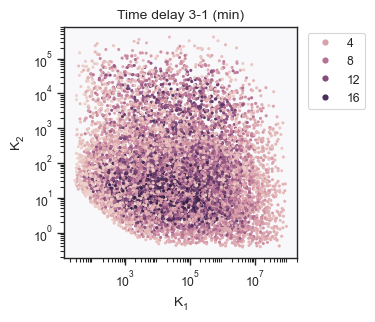

In [10]:
fit_df_pos = fit_df[(fit_df.time_delay_AC > 0) & (fit_df.time_delay_AE > 0)]

fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(data=fit_df_pos, x="K1", y="K2", hue="time_delay_AC", s=5, linewidth=0)
ax.set_facecolor("#F8F8FB")
ax.legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", markerscale=2)
ax.set_title("Time delay 3-1 (min)", fontsize=10)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$K_{1}$", fontsize=10)
ax.set_ylabel("$K_{2}$", fontsize=10)
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
# plt.savefig('Figure2_model_Timedelay_1-3.svg', format='svg', bbox_inches='tight', dpi=600)

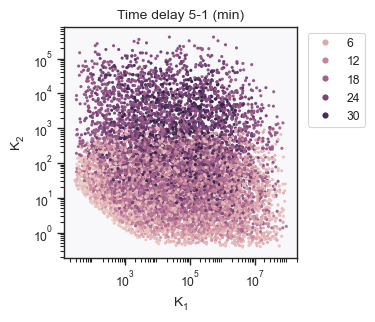

In [11]:
fit_df_pos = fit_df[(fit_df.time_delay_AC > 0) & (fit_df.time_delay_AE > 0)]

fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(data=fit_df_pos, x="K1", y="K2", hue="time_delay_AE", s=5, linewidth=0)
ax.set_facecolor("#F8F8FB")
ax.legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", markerscale=2)
ax.set_title("Time delay 5-1 (min)", fontsize=10)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$K_{1}$", fontsize=10)
ax.set_ylabel("$K_{2}$", fontsize=10)
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

# plt.savefig('Figure2_model_Timedelay_1-5.svg', format='svg', bbox_inches='tight', dpi=600)

### Additional analysis

Text(0, 0.5, '$k_{-1}$')

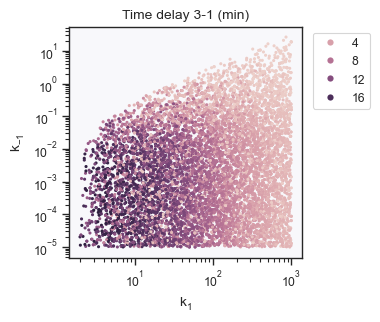

In [12]:
fit_df_pos = fit_df[(fit_df.time_delay_AC > 0) & (fit_df.time_delay_AE > 0)]

fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(data=fit_df_pos, x="k1", y="km1", hue="time_delay_AC", s=5, linewidth=0)
ax.set_facecolor("#F8F8FB")
ax.legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", markerscale=2)
ax.set_title("Time delay 3-1 (min)", fontsize=10)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$k_{1}$", fontsize=10)
ax.set_ylabel("$k_{-1}$", fontsize=10)
# plt.savefig('Figure2_model_k1_km1_Timedelay_1-3.svg', format='svg', bbox_inches='tight', dpi=600)

Text(0, 0.5, '$k_{-2}$')

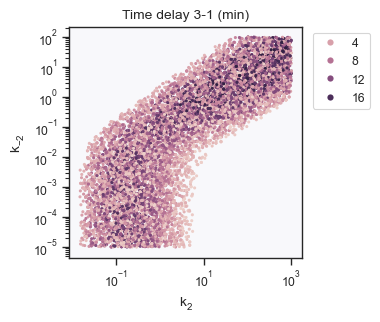

In [13]:
fit_df_pos = fit_df[(fit_df.time_delay_AC > 0) & (fit_df.time_delay_AE > 0)]

fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(data=fit_df_pos, x="k2", y="km2", hue="time_delay_AC", s=5, linewidth=0)
ax.set_facecolor("#F8F8FB")
ax.legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", markerscale=2)
ax.set_title("Time delay 3-1 (min)", fontsize=10)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$k_{2}$", fontsize=10)
ax.set_ylabel("$k_{-2}$", fontsize=10)
# plt.savefig('Figure2_model_k2_km2_Timedelay_1-3.svg', format='svg', bbox_inches='tight', dpi=600)

Text(0, 0.5, '$k_{-1}$')

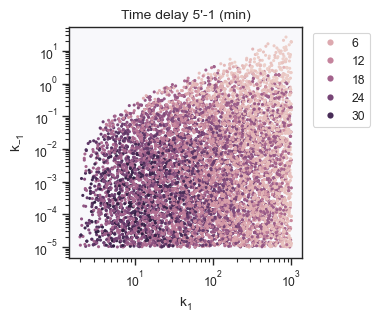

In [14]:
fit_df_pos = fit_df[(fit_df.time_delay_AC > 0) & (fit_df.time_delay_AE > 0)]

fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(data=fit_df_pos, x="k1", y="km1", hue="time_delay_AE", s=5, linewidth=0)
ax.set_facecolor("#F8F8FB")
ax.legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", markerscale=2)
ax.set_title("Time delay 5'-1 (min)", fontsize=10)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$k_{1}$", fontsize=10)
ax.set_ylabel("$k_{-1}$", fontsize=10)
# plt.savefig('Figure2_model_k1_km1_Timedelay_1-5.svg', format='svg', bbox_inches='tight', dpi=600)

Text(0, 0.5, '$k_{-2}$')

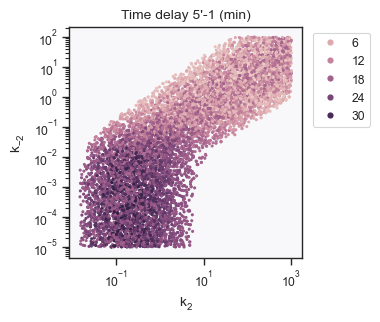

In [15]:
fit_df_pos = fit_df[(fit_df.time_delay_AC > 0) & (fit_df.time_delay_AE > 0)]

fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(data=fit_df_pos, x="k2", y="km2", hue="time_delay_AE", s=5, linewidth=0)
ax.set_facecolor("#F8F8FB")
ax.legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", markerscale=2)
ax.set_title("Time delay 5'-1 (min)", fontsize=10)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$k_{2}$", fontsize=10)
ax.set_ylabel("$k_{-2}$", fontsize=10)
# plt.savefig('Figure2_model_k2_km2_Timedelay_1-5.svg', format='svg', bbox_inches='tight', dpi=600)